In [1]:
import pandas as pd


In [68]:
df = pd.read_csv('../Data/heart_disease_uci.csv')


In [69]:
df.columns

Index(['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs',
       'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [70]:
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [71]:
df.shape

(920, 16)

## Analysis of dataset for cleaning

In [72]:
df.isna().sum()

id            0
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
num           0
dtype: int64

## Result:
- Manageable Columns:
| Column Name | Nan numbers     | Possible Solutions                   |
|:-----------:|:---------------:|:------------------------------------:|
|  trestbps   | 59 (~7% of all) |  numerical columns: Median or Mean   |
|  chol       | 30 (~3% of all) |  numerical columns: Median or Mean   |
|  fbs        | 90 (~10% of all)|  categorical/binary columns: mode    |
|  restecg    | 2  (~0% of all) |  categorical/binary columns: mode    |
|  thalch     | 55 (~7% of all) |  numerical columns: Median or Mean   |
|  exang      | 55 (~7% of all) |  categorical/binary columns: mode    |
|  oldpeak    | 62 (~7% of all) |  numerical columns: Median or Mean   |

- Columns with too many missing:

| Column Name | Nan numbers       | Possible Solutions                   |
|:-----------:|:-----------------:|:------------------------------------:|
|  slope      | 309 (~30% of all) |  categorical columns: mode or Dropping the column   |
|  ca         | 611 (~70% of all) |  Too much missing: Drop the column   |
|  thal       | 486 (~55% of all) |  Too much missing: Drop the colum    |

## Redandent Columns:
### "dataset", "id", and "num".
I save the num column as Boolaen named "target".

In [73]:
df["target"] = (df["num"] > 0).astype(int)
df = df.drop(columns=["num"])


In [74]:
df = df.drop(columns=["id", "dataset", "slope", "ca", "thal"])


In [75]:
num_cols = ["trestbps", "chol", "thalach", "oldpeak"]
cat_cols = ["fbs", "exang", "restecg"]

median_df = df.median(numeric_only=True)
median_df = pd.DataFrame(median_df)
median_df

,0
age,54.0
trestbps,130.0
chol,223.0
thalch,140.0
oldpeak,0.5
target,1.0


In [76]:
mode_df = pd.DataFrame(df.mode(numeric_only=False).iloc[0])
mode_df

,0
age,54
sex,Male
cp,asymptomatic
trestbps,120.0
chol,0.0
fbs,False
restecg,normal
thalch,150.0
exang,False
oldpeak,0.0


In [77]:
df["trestbps"].fillna(df["trestbps"].median(), inplace=True)
df["chol"].fillna(df["chol"].median(), inplace=True)
df["thalch"].fillna(df["thalch"].median(), inplace=True)
df["oldpeak"].fillna(df["oldpeak"].median(), inplace=True)
df["fbs"].fillna(df["fbs"].mode()[0], inplace=True)
df["exang"].fillna(df["exang"].mode()[0], inplace=True)
df["restecg"].fillna(df["restecg"].mode()[0], inplace=True)


C:\Users\arebr\AppData\Local\Temp\ipykernel_34472\1219696314.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["trestbps"].fillna(df["trestbps"].median(), inplace=True)
C:\Users\arebr\AppData\Local\Temp\ipykernel_34472\1219696314.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [78]:
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalch      0
exang       0
oldpeak     0
target      0
dtype: int64

## It is time to start training our model.
### But we have got problems with non-nimerical columns such as sex, fbs, thal, etc.

### Solution:
##### 1. Label Encoding for binary columns:
Each category is replaced with a number. It works fine for 'sex', 'fbs', 'exang'.
##### 2. One-Hot Encoding for multi-categorical columns:
It creates new columns for each category with 0/1. Also, it prevents the model from thinking categories have a numeric order.

In [81]:
df["restecg"].value_counts()


restecg
normal              553
lv hypertrophy      188
st-t abnormality    179
Name: count, dtype: int64

In [82]:
df["sex"] = df["sex"].map({"Male": 1, "Female": 0})
df["fbs"] = df["fbs"].map({True: 1, False: 0})
df["exang"] = df["exang"].map({True: 1, False: 0})

df = pd.get_dummies(df, columns=["cp", "restecg"], drop_first=True)

df.columns

Index(['age', 'sex', 'trestbps', 'chol', 'fbs', 'thalch', 'exang', 'oldpeak',
       'target', 'cp_atypical angina', 'cp_non-anginal', 'cp_typical angina',
       'restecg_normal', 'restecg_st-t abnormality'],
      dtype='object')

In [83]:
df.head

<bound method NDFrame.head of      age  sex  trestbps   chol  fbs  thalch  exang  oldpeak  target  \
0     63    1     145.0  233.0    1   150.0      0      2.3       0   
1     67    1     160.0  286.0    0   108.0      1      1.5       1   
2     67    1     120.0  229.0    0   129.0      1      2.6       1   
3     37    1     130.0  250.0    0   187.0      0      3.5       0   
4     41    0     130.0  204.0    0   172.0      0      1.4       0   
..   ...  ...       ...    ...  ...     ...    ...      ...     ...   
915   54    0     127.0  333.0    1   154.0      0      0.0       1   
916   62    1     130.0  139.0    0   140.0      0      0.5       0   
917   55    1     122.0  223.0    1   100.0      0      0.0       1   
918   58    1     130.0  385.0    1   140.0      0      0.5       0   
919   62    1     120.0  254.0    0    93.0      1      0.0       1   

     cp_atypical angina  cp_non-anginal  cp_typical angina  restecg_normal  \
0                 False           False

In [84]:
df["cp_atypical angina"] = df["cp_atypical angina"].map({True: 1, False: 0})
df["cp_non-anginal"] = df["cp_non-anginal"].map({True: 1, False: 0})
df["cp_typical angina"] = df["cp_typical angina"].map({True: 1, False: 0})
df["restecg_normal"] = df["restecg_normal"].map({True: 1, False: 0})
df["restecg_st-t abnormality"] = df["restecg_st-t abnormality"].map({True: 1, False: 0})

df.head

<bound method NDFrame.head of      age  sex  trestbps   chol  fbs  thalch  exang  oldpeak  target  \
0     63    1     145.0  233.0    1   150.0      0      2.3       0   
1     67    1     160.0  286.0    0   108.0      1      1.5       1   
2     67    1     120.0  229.0    0   129.0      1      2.6       1   
3     37    1     130.0  250.0    0   187.0      0      3.5       0   
4     41    0     130.0  204.0    0   172.0      0      1.4       0   
..   ...  ...       ...    ...  ...     ...    ...      ...     ...   
915   54    0     127.0  333.0    1   154.0      0      0.0       1   
916   62    1     130.0  139.0    0   140.0      0      0.5       0   
917   55    1     122.0  223.0    1   100.0      0      0.0       1   
918   58    1     130.0  385.0    1   140.0      0      0.5       0   
919   62    1     120.0  254.0    0    93.0      1      0.0       1   

     cp_atypical angina  cp_non-anginal  cp_typical angina  restecg_normal  \
0                     0               0

## Now, we move into the Modeling.
### we start with splitting Features and Target, then Train and Test.

In [86]:
X = df.drop("target", axis=1)
y = df["target"]


In [87]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [88]:
from sklearn.linear_model import LogisticRegression


log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [90]:
# To Save My Model into the Local:
import joblib

joblib.dump(log_reg, "logistic_model.pkl")

['logistic_model.pkl']

## Evaluation of the model

In [91]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8315217391304348
Confusion Matrix:
 [[62 20]
 [11 91]]
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.76      0.80        82
           1       0.82      0.89      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.83       184
weighted avg       0.83      0.83      0.83       184



In [92]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)


                     Feature  Coefficient
1                        sex     1.165924
6                      exang     1.012725
7                    oldpeak     0.489403
4                        fbs     0.400598
0                        age     0.035117
2                   trestbps     0.003779
3                       chol    -0.003433
5                     thalch    -0.013463
12  restecg_st-t abnormality    -0.057801
11            restecg_normal    -0.275403
10         cp_typical angina    -0.909070
9             cp_non-anginal    -1.099606
8         cp_atypical angina    -1.851401


In [93]:
y_prob = log_reg.predict_proba(X_test)[:, 1] 
y_pred_new = (y_prob >= 0.4).astype(int)     


In [95]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred_new))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_new))
print("Classification Report:\n", classification_report(y_test, y_pred_new))


Accuracy: 0.8152173913043478
Confusion Matrix:
 [[56 26]
 [ 8 94]]
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.68      0.77        82
           1       0.78      0.92      0.85       102

    accuracy                           0.82       184
   macro avg       0.83      0.80      0.81       184
weighted avg       0.82      0.82      0.81       184



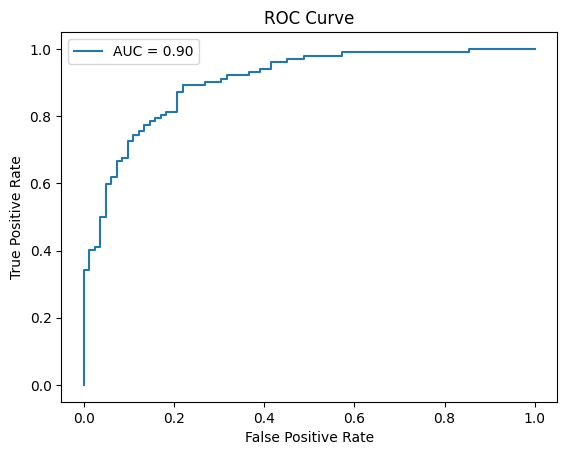

In [96]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Conclusion

In this project, a logistic regression model was developed to predict the possibility of heart disease using patient health records. The model achieved an accuracy of 82% with balanced precision and recall, indicating reliable performance in identifying both positive and negative cases. Feature analysis revealed that chest pain type, sex, exercise-induced angina, and oldpeak were among the most influential predictors.

Beyond accuracy, the ROC curve analysis highlighted the robustness of the model, with an AUC score of 0.90, suggesting excellent ability to distinguish between patients with and without heart disease. This strong performance enables the model to be adapted to various decision thresholds, thereby balancing the trade-off between detecting more true positives and reducing false alarms. Although limited by dataset size and model simplicity, the findings demonstrate the potential of combining machine learning with data visualization to support healthcare professionals in risk assessment and early intervention.

**Furthermore, I will attempt to develop another model to address the small dataset size issue by employing the cross-validation approach.**